In [1]:
import os
import json
import cv2
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from tqdm import tqdm
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

In [2]:
file = 'F:\\Explore\\mechine\\paper\\dataset\\lung'

cls=[]
datas={}
for i in os.listdir(file):
    cls.append(i)
    #globals()['{}'.format(i)]=[]
    datas[i]=[]
    for j in os.listdir(os.path.join(file,i)):
        datas[i].append(os.path.join(file,i,j))

In [3]:
#cls=['Bengning_cases', 'Malignant_cases', 'Normal_cases']
datas.keys(),len(datas['Bengning_cases']),len(datas['Malignant_cases']),len(datas['Normal_cases'])
#datas.clear()

(dict_keys(['Bengning_cases', 'Malignant_cases', 'Normal_cases']),
 120,
 561,
 416)

In [4]:
f=tf.io.read_file(datas['Bengning_cases'][0])
f=tf.image.decode_jpeg(f)
f.shape

2023-08-23 11:48:16.701120: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-23 11:48:16.701253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: xXramXx
2023-08-23 11:48:16.701279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: xXramXx
2023-08-23 11:48:16.701553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.105.17
2023-08-23 11:48:16.701651: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  525.105.17  Release Build  (dvs-builder@U16-T02-30-1)  Tue Mar 28 22:29:15 UTC 2023
GCC version:  gcc version 11.3.0 (Ubuntu 11.3.0-1ubuntu

TensorShape([512, 512, 3])

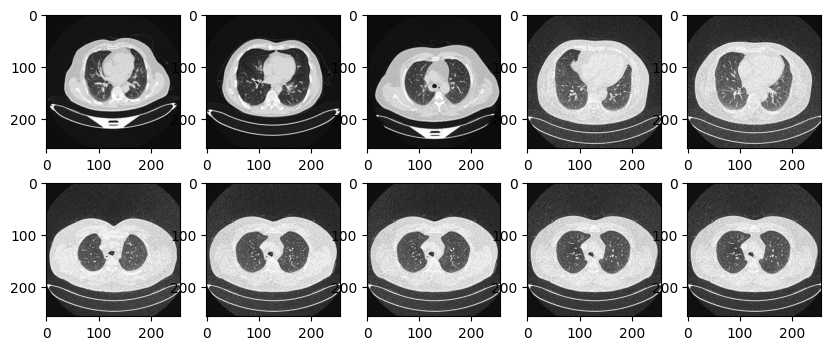

In [4]:
for i in range(10):
    img = tf.io.read_file(datas['Bengning_cases'][i])
    img1 = tf.image.decode_jpeg(img)
    img2 = tf.keras.layers.Lambda(lambda x: x / 255)(img1)
    img3 = tf.image.resize(img2,[256,256])
    img4 = tf.image.rgb_to_grayscale(img3)
    plt.subplot(2, 5,i + 1)
    plt.imshow(img4,cmap='gray')
    plt.gcf().set_size_inches(10, 4)
plt.show()

In [5]:
def shape_data(img):
    img=cv2.resize(img,(256,256))
    img=cv2.normalize(img,None,alpha=0,beta=1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return img 

In [6]:
train,train1=[],[]

for c,k in enumerate(datas.keys()):
    for j in datas[k]:
        img2=cv2.imread(os.path.join(file,"images",j))
        train1.append([shape_data(img2),k])
        train.append([img2,c])

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def train_split(train):
    train_data,lables=[],[]
    random.shuffle(train)
    for dat, lab in train:
        lables.append(lab)
        train_data.append(dat)
        
    #train_data=np.array(train_data).reshape(-1,512,512,3)
    train_data=np.array(train_data).reshape(-1,256,256,3)
    lables=le.fit_transform(lables)
    lables=np.array(lables)
    return train_data,lables

In [8]:
train,label=train_split(train1)
set(label),label.shape

({0, 1, 2}, (1097,))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.22, random_state=42)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(tf.keras.applications.VGG16(include_top = False, weights="imagenet", input_shape=(256, 256, 3)))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(3, activation = 'softmax'))
model.layers[0].trainable = False

2023-08-23 12:09:17.888957: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-23 12:09:17.889104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: xXramXx
2023-08-23 12:09:17.889134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: xXramXx
2023-08-23 12:09:17.889445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.105.17
2023-08-23 12:09:17.889564: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  525.105.17  Release Build  (dvs-builder@U16-T02-30-1)  Tue Mar 28 22:29:15 UTC 2023
GCC version:  gcc version 11.3.0 (Ubuntu 11.3.0-1ubuntu

In [9]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [10]:
%%time
#results = model.fit_generator(training_set,validation_data=test_set,epochs=20,steps_per_epoch=len(training_set),validation_steps=len(test_set))
results = model.fit(X_train, y_train, validation_split=0.2, batch_size=10, epochs=15)#, callbacks=callbacks)
model.save('lung_class_VGG16_model_1.h5')

2023-08-23 12:09:25.515287: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 672399360 exceeds 10% of free system memory.


Epoch 1/15
86/86 [==============================] - 91s 1s/step - loss: 0.8919 - accuracy: 0.5462
Epoch 2/15
86/86 [==============================] - 92s 1s/step - loss: 0.7859 - accuracy: 0.7439
Epoch 3/15
86/86 [==============================] - 93s 1s/step - loss: 0.7167 - accuracy: 0.7661
Epoch 4/15
86/86 [==============================] - 97s 1s/step - loss: 0.6627 - accuracy: 0.7965
Epoch 5/15
86/86 [==============================] - 99s 1s/step - loss: 0.6224 - accuracy: 0.8117
Epoch 6/15
86/86 [==============================] - 101s 1s/step - loss: 0.5904 - accuracy: 0.8292
Epoch 7/15
86/86 [==============================] - 102s 1s/step - loss: 0.5586 - accuracy: 0.8327
Epoch 8/15
86/86 [==============================] - 103s 1s/step - loss: 0.5324 - accuracy: 0.8398
Epoch 9/15
86/86 [==============================] - 104s 1s/step - loss: 0.5116 - accuracy: 0.8421
Epoch 10/15
86/86 [==============================] - 104s 1s/step - loss: 0.4964 - accuracy: 0.8444
Epoch 11/15
86

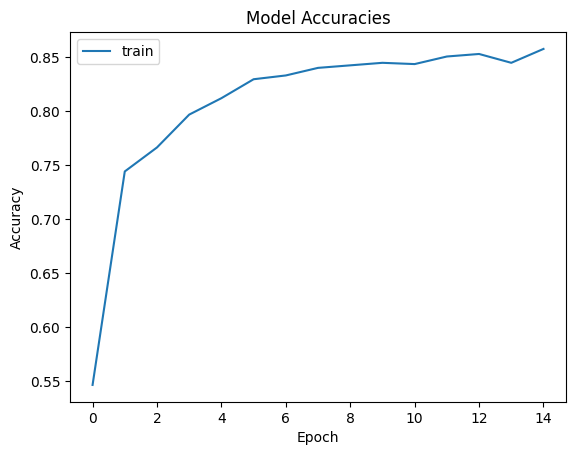

In [14]:
# accuray plot
plt.plot(results.history['accuracy'])
#plt.plot(results.history['val_accuracy'])
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

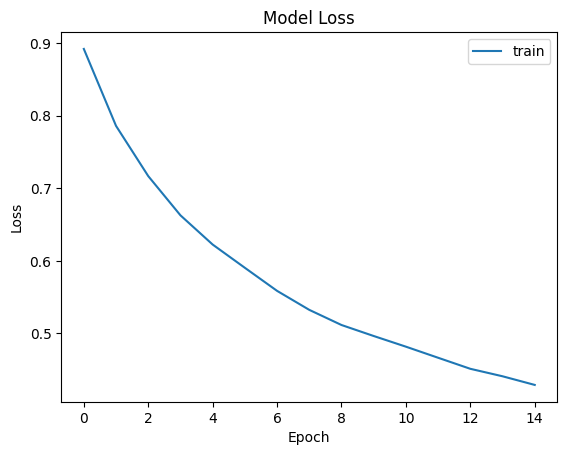

In [15]:
# losses plot
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
# PHASE 2

In [10]:
import sys

sys.path.insert(0, '/media/ram/ubuntuspace/Explore/mechine/paper/pro/models/')
from classify_cnn import cnn_model

In [11]:
input_shape = (256,256, 3)
classes = 3

mdl=cnn_model(input_shape,classes)
#mdl.build(input_shape)
print(mdl.summary())

2023-08-16 12:34:59.213464: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-16 12:34:59.213523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: xXramXx
2023-08-16 12:34:59.213530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: xXramXx
2023-08-16 12:34:59.213691: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.105.17
2023-08-16 12:34:59.213719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  525.105.17  Release Build  (dvs-builder@U16-T02-30-1)  Tue Mar 28 22:29:15 UTC 2023
GCC version:  gcc version 11.3.0 (Ubuntu 11.3.0-1ubuntu

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        1

In [12]:
mdl.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate = 0.0001),metrics=['accuracy'])

In [56]:
tf.test.is_gpu_available() # test for using gpu
tf.test.is_gpu_available(cuda_only=True) # testing for using cuda

False

In [14]:
training = mdl.fit(X_train, y_train, validation_split=0.2, batch_size=10, epochs=15)#, callbacks=callbacks)
mdl.save('lung_class_own_model_1.h5')

Epoch 1/15


2023-08-16 12:36:03.621943: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 537919488 exceeds 10% of free system memory.


69/69 [==============================] - 25s 361ms/step - loss: 0.7463 - accuracy: 0.6769 - val_loss: 0.6823 - val_accuracy: 0.7895
Epoch 2/15
69/69 [==============================] - 25s 367ms/step - loss: 0.5003 - accuracy: 0.8056 - val_loss: 0.4407 - val_accuracy: 0.9006
Epoch 3/15
69/69 [==============================] - 25s 361ms/step - loss: 0.2973 - accuracy: 0.8977 - val_loss: 0.4113 - val_accuracy: 0.8304
Epoch 4/15
69/69 [==============================] - 26s 371ms/step - loss: 0.1927 - accuracy: 0.9401 - val_loss: 0.2185 - val_accuracy: 0.9298
Epoch 5/15
69/69 [==============================] - 25s 365ms/step - loss: 0.1134 - accuracy: 0.9635 - val_loss: 0.1415 - val_accuracy: 0.9825
Epoch 6/15
69/69 [==============================] - 25s 367ms/step - loss: 0.0629 - accuracy: 0.9868 - val_loss: 0.1240 - val_accuracy: 0.9649
Epoch 7/15
69/69 [==============================] - 25s 369ms/step - loss: 0.0325 - accuracy: 0.9956 - val_loss: 0.1092 - val_accuracy: 0.9708
Epoch 8/15

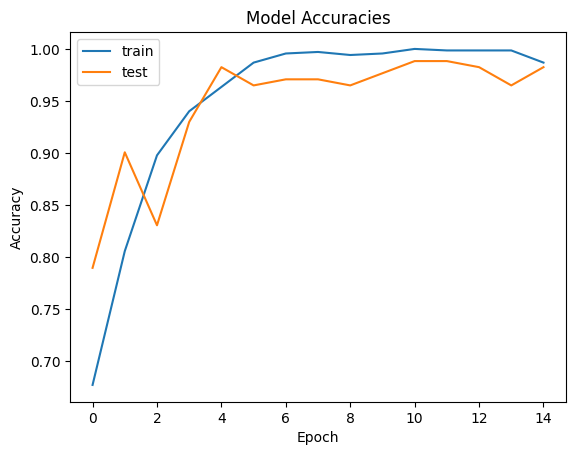

In [15]:
# accuray plot
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

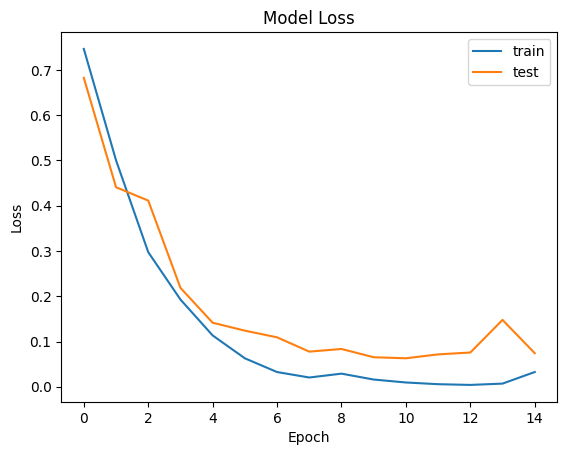

In [17]:
# losses plot
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()